In [1]:
# # Setup and Data Loading
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats, optimize, integrate
from scipy.special import ndtr
from sklearn.mixture import GaussianMixture

returns = pd.read_csv("DJIA30stockreturns.csv", header=None)

print(f"Data shape: {returns.shape}")
# Shoudl be (7999, 25)
print(f"First few rows: \n{returns.head()}")

Data shape: (8000, 25)
First few rows: 
         0         1         2         3         4         5         6   \
0  0.668899  1.055193  2.409755  1.047484 -1.633642  0.216216  0.317377   
1  0.346067 -1.055193 -0.397615  0.419288 -1.302564 -0.112374  0.684213   
2  0.318387 -0.445371 -1.396155 -0.621172 -1.501079  0.328124 -1.346555   
3  0.660068 -0.727276  1.188769 -0.642003  0.948302  0.849827 -0.988388   
4 -0.978456 -2.214113 -1.188769 -0.646151 -0.751883 -0.102731 -2.721256   

         7         8         9   ...        15        16        17        18  \
0  0.883838 -2.817088  0.400001  ...  0.561799 -2.247286  0.351494 -0.170358   
1  1.136433  2.120221  0.216001  ...  2.893311 -2.057383  1.559703 -1.980263   
2 -0.250313 -0.701757 -1.051148  ... -2.479602  2.962367 -0.860399 -1.828204   
3  0.619630  1.398624  1.663378  ...  1.528100 -0.451468 -0.881926  1.828204   
4 -1.001310  2.739897 -3.133372  ... -0.275103 -1.826535 -2.131671  0.000000   

         19        20       

**1. Model Density Functions**

In [ ]:
# ## 1.1 Gaussian Distribution

# %%
def gaussian_pdf(x, mu, sigma):
    return stats.norm.pdf(x, loc=mu, scale=sigma)

# We could compute this analytically (mu_hat = mean(data) sigma_hat = std.(data))
# but for consistency with other models, let's keep MLE structure

def gaussian_loglik(params, data):
    """Negative log_likelihood for optimization"""
    mu, sigma = params
    if sigma <= 0:
        return np.inf
    return -np.sum(stats.norm.logpdf(data, loc=mu, scale=sigma))

def fit_gaussian(data):
    """Fit Gaussian via MLE"""
    mu_init = np.mean(data)
    sigma_init = np.std(data)

    result = optimize.minimize(
        gaussian_loglik,
        x0 = [mu_init, sigma_init],
        args = (data, ),
        method = 'L-BFGS-B',
        bounds = [(-np.inf, np.inf), (1e-6, np.inf)]
    )

    return result.x, -result.fun # params, log-likelihood

In [5]:
# ## 1.2 Mixture of Gaussians

# %%
def mixture_gaussian_pdf(x, params, K):
    """
    PDF of K-component Guassian mixture
    params: [w1, ..., w_{K-1}, mu1, ..., muK, sigma1, ..., sigmaK]
    weights are constrained to sum to 1
    """
    assert len(params) == 3*K - 1

    weights = np.zeros(K)
    weights[:-1] = params[:K-1]
    weights[-1] = 1 - np.sum(weights[:-1])

    mus = params[K-1: 2*K-1]
    sigmas = params[2*K-1: 3*K-1]

    pdf = np.zeros_like(x)
    for i in range(K):
        pdf += weights[i] * stats.norm.pdf(x, loc=mus[i], scale=sigmas[i])

    return pdf

def mixture_gaussian_loglik(params, data, K):
    """Negative log_likelihood for K-component Gaussian mixture"""
    assert len(params) == 3*K - 1

    weights = np.zeros(K)
    weights[:-1] = params[:K-1]
    weights[-1] = 1 - np.sum(weights[:-1])

    # Check constraints
    if np.any(weights <= 1e-3) or np.any(weights >= 1 - 1e-3): # stricter constraints
        return np.inf
    if not np.isclose(np.sum(weights), 1.0, atol=1e-6):  # Ensure they sum to 1
        return np.inf

    mus = params[K-1: 2*K-1]
    sigmas = params[2*K-1: 3*K-1]

    if np.any(sigmas <= 1e-3):
        return np.inf

    # Compute log-likelihood
    pdf_vals = mixture_gaussian_pdf(data, params, K)

    # Add small epsilon to prevent log(0)
    pdf_vals = np.maximum(pdf_vals, 1e-300)

    if np.any(pdf_vals <= 0) or np.any(~np.isfinite(pdf_vals)):
        return np.inf

    log_lik = np.sum(np.log(pdf_vals))

    if not np.isfinite(log_lik):
        return np.inf

    return -log_lik

def fit_mixture_gaussian(data, K):
    """Fit K-component Gaussian mixture via MLE"""
    # Use sklearn for inititalization
    # could do it ourselves but this is easier
    gmm = GaussianMixture(n_components=K, random_state=42, max_iter=100)
    gmm.fit(data.reshape(-1, 1))

    # Extract initial params
    weights_init = gmm.weights_[:-1]
    mus_init = gmm.means_.flatten()
    sigmas_init = np.sqrt(gmm.covariances_).flatten()

    x0 = np.concatenate([weights_init, mus_init, sigmas_init])

    # Set up bounds
    bounds = []
    for i in range(K-1): # weights
        bounds.append((1e-6, 1 - 1e-6))
    for i in range(K): # means
        bounds.append((-np.inf, np.inf))
    for i in range(K): # sigmas
        bounds.append((1e-6, np.inf))

    result = optimize.minimize(
        mixture_gaussian_loglik,
        x0 = x0,
        args = (data, K),
        method = 'L-BFGS-B',
        bounds = bounds
    )

    return result.x, -result.fun # params, log-likelihood

In [ ]:
# ## 1.3 Weighted Sum of Chi-Squared(1) with Location
# ### Characteristic Function Approach

TMAX = 50.0   # may need to play with this
N_T  = 2000   # number of points in t-grid
t_grid = np.linspace(0.0, TMAX, N_T)
dt = t_grid[1] - t_grid[0]

def weighted_chisq_cf_grid(weights, location):
    """
    Characteristic function of weighted sum of chi-squared(1) + location
    X = location + sum(weights[k] * Z_k) where Z_k ~chi^2(1)

    CF of chi^2(1): (1 - 2it)^(-1/2)

    Returns: phi(t_grid) - shape (N_T,)
    """
    phi = np.exp(1j * t_grid * location)
    for w in weights:
        phi *= (1 - 2j * t_grid * w) ** (-0.5)
    return phi

def weighted_chisq_pdf_from_phi(x_array, phi):
    """
    Given data x_array (shape (n, )) and phi(t_grid),
    approximate the pdf at all x via numeric integration.

    Uses Gil-Pelaez formula:
    f(x) = (1/π) * Re[ ∫_0^∞ exp(-itx) * φ(t) dt ]
    """
    x_array = np.asarray(x_array)
    # phase shape: (n_data, N_T)
    phase = np.exp(-1j * np.outer(x_array, t_grid))
    # integrand shape: (n_data, N_T)
    integrand = phase * phi  # broadcasts phi across rows
    # Trapezoidal rule approximation
    # First and last points get weight 0.5
    weights = np.ones(N_T)
    weights[0] = weights[-1] = 0.5
    vals = np.real(np.sum(integrand * weights, axis=1) * dt)
    return vals / np.pi

def weighted_chisq_loglik(params, data, K):
    """Negative log-likelihood"""
    weights = params[:K]
    location = params[K]

    if np.any(weights <= 0):
        return np.inf

    # Check weights are reasonable (avoid numerical issues)
    if np.any(weights > 100):  # arbitrary large bound
        return np.inf

    # Compute CF once for these parameters
    phi = weighted_chisq_cf_grid(weights, location)

    # Evaluate PDF at all data points via CF inversion
    pdf_vals = weighted_chisq_pdf_from_phi(data, phi)

    if np.any(pdf_vals <= 0) or np.any(~np.isfinite(pdf_vals)):
        return np.inf

    return -np.sum(np.log(pdf_vals))


def fit_weighted_chisq(data, K):
    """Fit weighted chi-squared model via MLE"""
    # Initialize weights uniformly, location near zero
    weights_init = np.ones(K) / K
    location_init = np.mean(data)

    x0 = np.concatenate([weights_init, [location_init]])

    bounds = [(1e-6, np.inf) for _ in range(K)] + [(-np.inf, np.inf)]

    result = optimize.minimize(
        weighted_chisq_loglik,
        x0 = x0,
        args = (data, K),
        method = 'L-BFGS-B',
        bounds = bounds,
        options = {'maxiter': 100} # limit due to CF inversion
    )

    return result.x, -result.fun # params, log-likelihood

In [ ]:
# ## 1.4 Location-Scale Noncental t

def nct_pdf(x, df, nc, loc, scale):
    """PDF of noncentral t-distribution with location and scale"""
    z = (x - loc) / scale
    return stats.nct.pdf(z, df, nc) / scale


def nct_loglik(params, data):
    """Negative log-likelihood"""
    df, nc, loc, scale = params

    if df <= 0 or scale <= 0:
        return np.inf

    pdf_vals = nct_pdf(data, df, nc, loc, scale)
    if np.any(pdf_vals <= 0) or np.any(~np.isfinite(pdf_vals)):
        return np.inf

    log_lik = np.sum(np.log(pdf_vals))
    return -log_lik


def fit_nct(data):
    """Fit noncentral t via MLE"""
    # Initialize
    df_init = 5
    nc_init = 0
    loc_init = np.mean(data)
    scale_init = np.std(data)

    x0 = [df_init, nc_init, loc_init, scale_init]

    bounds = [(0.1, 100), (-10, 10), (-np.inf, np.inf), (1e-6, np.inf)]

    result = optimize.minimize(
        nct_loglik,
        x0 = x0,
        args = (data, ),
        method = 'L-BFGS-B',
        bounds = bounds
    )

    return result.x, -result.fun # params, log-likelihood


**2. Fit all models to all stocks**

In [ ]:
# # 2. Fit All Models to All Stocks

def fit_all_models(data):
    """
    Fit all models to a single returns series
    Returns: dict with results for each model
    """
    results = {}

    print("Fitting Gaussian...")
    params, loglik = fit_gaussian(data)
    results['Gaussian'] = {
        'params': params,
        'loglik': loglik,
        'n_params': 2
    }

    print("Fitting Mixture Gaussian (K=2)...")
    params, loglik = fit_mixture_gaussian(data, K = 2)
    results['MixGauss_K2'] = {
        'params': params,
        'loglik': loglik,
        'n_params': 5 # 1 weight + 2 means + 2 sigmas
    }

    print("Fitting Mixture Gaussian (K=3)...")
    params, loglik = fit_mixture_gaussian(data, K = 3)
    results['MixGauss_K3'] = {
        'params': params,
        'loglik': loglik,
        'n_params': 8
    }

    # Weighted Chi-Squared models
    for K in [2, 3, 4, 5]:
        print(f"Fitting Weighted Chi Squared (K={K})...")
        try:
            params, loglik = fit_weighted_chisq(data, K)
            results[f"WeightedChiSq_K{K}"] = {
                'params': params,
                'loglik': loglik,
                'n_params': K + 1 # K weights + 1 location
            }
        except Exception as e:
            print(f" Warning: Failed to fit WeightedChiSq_K{K}: {str(e)}")
            results[f'WeightedChiSq_K{K}'] = {
                'params': None,
                'loglik': -np.inf,
                'n_params': K + 1
            }

    print("Fitting Noncentral t...")
    params, loglik = fit_nct(data)
    results['NCT'] = {
        'params': params,
        'loglik': loglik,
        'n_params': 4 # df, nc, loc, scale
    }

    return results

In [ ]:
# Fit all models to all stocks
all_results = {}

for col in returns.columns:
    print(f"\n{'='*60}")
    print(f"Fitting models for {col}")
    print(f"{'='*60}")

    data = returns[col].values
    all_results[col] = fit_all_models(data)

    break # temporary so to only fit the first series for now




Fitting models for 0
Fitting Gaussian...
Fitting Mixture Gaussian (K=2)...
Fitting Mixture Gaussian (K=3)...


/usr/local/lib/python3.12/dist-packages/scipy/optimize/_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]


Fitting Weighted Chi Squared (K=2)...
Fitting Weighted Chi Squared (K=3)...
Fitting Weighted Chi Squared (K=4)...
Fitting Weighted Chi Squared (K=5)...
Fitting Noncentral t...


In [ ]:
# # 3. Compute Information Criteria
def compute_aic_bic(loglik, n_params, n_obs):
    """Compute AIC and BIC"""
    aic = 2 * n_params - 2 * loglik
    bic = n_params * np.log(n_obs) - 2 * loglik
    return aic, bic

# Add AIC and BIC to results
for stock in all_results:
    n_obs = len(returns[stock])
    for model in all_results[stock]:
        loglik = all_results[stock][model]['loglik']
        n_params = all_results[stock][model]['n_params']
        aic, bic = compute_aic_bic(loglik, n_params, n_obs)
        all_results[stock][model]['AIC'] = aic
        all_results[stock][model]['BIC'] = bic



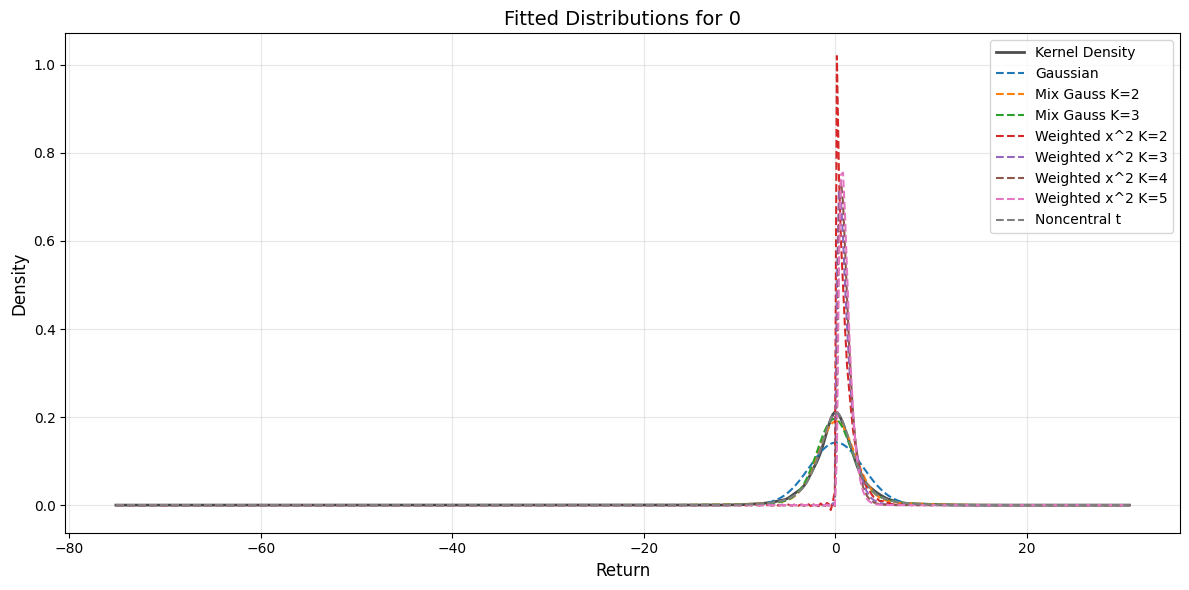

In [ ]:
# # 4. Visualization for First Stock
# Plot for first stock
first_stock = returns.columns[0]
data_first = returns[first_stock].values

fig, ax = plt.subplots(figsize=(12,6))

# Kernel density estimate
from scipy.stats import gaussian_kde
kde = gaussian_kde(data_first)
x_range = np.linspace(data_first.min() - 2, data_first.max() + 2, 500)
ax.plot(x_range, kde(x_range), 'k-', linewidth=2, label='Kernel Density', alpha=0.7)

# Plot fitted distributions
colors = plt.cm.tab10(np.linspace(0, 1, 10))

# Gaussian
params = all_results[first_stock]['Gaussian']['params']
y = gaussian_pdf(x_range, params[0], params[1])
ax.plot(x_range, y, '--', label='Gaussian', linewidth=1.5)

# Mixture Gaussians
for K, label in [(2, 'Mix Gauss K=2'), (3, 'Mix Gauss K=3')]:
    params = all_results[first_stock][f'MixGauss_K{K}']['params']
    y = mixture_gaussian_pdf(x_range, params, K)
    ax.plot(x_range, y, '--', label=label, linewidth=1.5)

# Weighted Chi-Squared (if fitted successfully)
for K in [2, 3, 4, 5]:
    model_key = f"WeightedChiSq_K{K}"
    if all_results[first_stock][model_key]['params'] is not None:
        params = all_results[first_stock][model_key]['params']
        weights = params[:K]
        location = params[K]
        phi = weighted_chisq_cf_grid(weights, location)
        y = weighted_chisq_pdf_from_phi(x_range, phi)
        ax.plot(x_range, y, '--', label=f"Weighted x^2 K={K}", linewidth=1.5)

# NCT
params = all_results[first_stock]['NCT']['params']
y = nct_pdf(x_range, params[0], params[1], params[2], params[3])
ax.plot(x_range, y, '--', label='Noncentral t', linewidth=1.5)

ax.set_xlabel('Return', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title(f'Fitted Distributions for {first_stock}', fontsize=14)
ax.legend(loc='best')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
# # 5. Model Selection Table
# Create summary table
model_selection = []

for stock in returns.columns:
    best_loglik = max(all_results[stock].items(),
                      key=lambda x: x[1]['loglik'])[0]
    best_aic = min(all_results[stock].items(),
                   key=lambda x: x[1]['AIC'])[0]
    best_bic = min(all_results[stock].items(),
                   key=lambda x: x[1]['BIC'])[0]

    model_selection.append({
        'Stock': stock,
        'Best (LogLik)': best_loglik,
        'Best (AIC)': best_aic,
        'Best (BIC)': best_bic
    })

df_selection = pd.DataFrame(model_selection)
print("\nModel Selection Summary:")
print(df_selection.to_string(index=False))


KeyError: 1

In [ ]:
# # 6. Value-at-Risk Calculations